In [1]:
import librosa
import numpy as np
import csv

import matplotlib.pyplot as plt
%matplotlib inline

# Summary
Given note data as a sequence of (start time, end time, midi value) for the vocal melody, and MIXTURE audio:

1) Run a multif0 tracking algorithm (in this case, Deep Salience) on the mixture to produce a salience matrix.

2) Mask the salience matrix everywhere except where the vocal melody notes are active.

3) Return the estimated f0 sequence by computing the argmax over the erased salience matrix.

## Load annotated note data

In [2]:
with open("MusicDelta_Rock_STEM_05_notes.csv", 'r') as fhandle:
    reader = csv.reader(fhandle, delimiter=',')
    note_sequence = []
    for line in reader:
        # lines are (note_start, note_end, midi_value)
        note_sequence.append([float(line[0]), float(line[1]), int(line[2])])

## Load pre-computed salience data

Computed using this script: https://github.com/rabitt/ismir2017-deepsalience/blob/master/predict/predict_on_audio.py

$ python predict_on_audio.py MusicDelta_Rock_MIX.wav 'multif0' save_path

$ python predict_on_audio.py MusicDelta_Rock_MIX.wav 'vocal' save_path

In [3]:
# salience that emphasizes only vocals, high precision low recall
vocal_sal_data = np.load("MusicDelta_Rock_MIX_vocal_salience.npz")
# salience that emphasizes all pitches, low precision high recall
sal_data = np.load("MusicDelta_Rock_MIX_multif0_salience.npz")

sal_times = sal_data['times']
sal_freqs_hz = sal_data['freqs']
sal_freqs_midi = librosa.hz_to_midi(sal_freqs_hz)

# average vocal and mf0 salience data
mf0_salience = 0.5*(sal_data['salience'] + vocal_sal_data['salience'])

## Plot Salience Matrix

(-0.5, 1127.5, -0.5, 359.5)

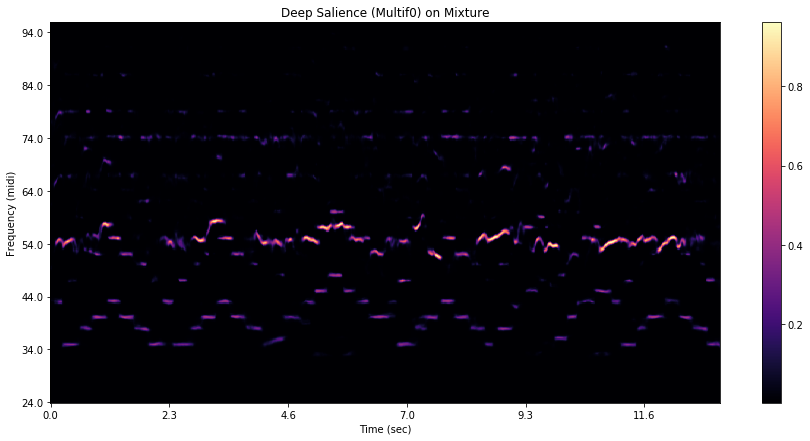

In [4]:
plt.figure(figsize=(15, 7))
plt.title("Deep Salience (Multif0) on Mixture")
plt.imshow(mf0_salience, origin='lower', cmap='magma')
plt.xticks(np.arange(len(sal_times))[::200], np.round(sal_times[::200], 1))
plt.yticks(np.arange(len(sal_freqs_midi))[::50], np.round(sal_freqs_midi[::50], 1))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (midi)")
plt.colorbar()
plt.axis('tight')

## Compute Vocal Note Mask & Masked Salience

In [5]:
# initialize mask to have the same size as the salience
vocal_note_mask = np.zeros(mf0_salience.shape)

# size above and below midi note value to allow in mask
## higher values allows for more expressive singing e.g. vibrato
## lower values will prevent noise from other instruments from interfering in the estimate.
midi_thresh = 2  

# padding to add to mask before and after the start/end of a note
## make this a small positive number if the timings aren't accurate
time_buffer = 0.0

# loop over notes to create mask
for note_start, note_end, note_midi in note_sequence:

    # find closest point in time grid to note start/end
    t_start = np.argmin(np.abs(sal_times - (note_start - time_buffer)))
    t_end = np.argmin(np.abs(sal_times - (note_end + time_buffer)))

    # find closest point in frequency grid to note midi boundaries
    f_start = np.argmin(np.abs(sal_freqs_midi - (note_midi - midi_thresh)))
    f_end = np.argmin(np.abs(sal_freqs_midi - (note_midi + midi_thresh)))

    vocal_note_mask[f_start:f_end, t_start:t_end] = 1

# compute masked salience
masked_salience = mf0_salience * vocal_note_mask

## Plot results

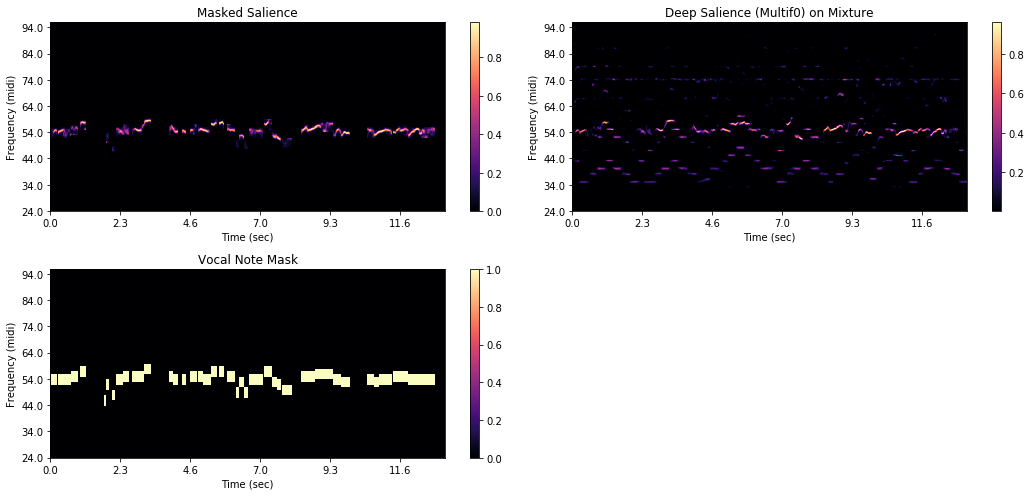

In [6]:
plt.figure(figsize=(15, 7))
plt.subplot(222)
plt.title("Deep Salience (Multif0) on Mixture")
plt.imshow(mf0_salience, origin='lower', cmap='magma')
plt.xticks(np.arange(len(sal_times))[::200], np.round(sal_times[::200], 1))
plt.yticks(np.arange(len(sal_freqs_midi))[::50], np.round(sal_freqs_midi[::50], 1))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (midi)")
plt.colorbar()
plt.axis('tight')

plt.subplot(221)
plt.title("Masked Salience")
# plotting square root of masked salience to show better contrast.
plt.imshow(masked_salience**0.5, origin='lower', cmap='magma')
plt.xticks(np.arange(len(sal_times))[::200], np.round(sal_times[::200], 1))
plt.yticks(np.arange(len(sal_freqs_midi))[::50], np.round(sal_freqs_midi[::50], 1))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (midi)")
plt.colorbar()
plt.axis('tight')

plt.subplot(223)
plt.title("Vocal Note Mask")
plt.imshow(vocal_note_mask, origin='lower', cmap='magma')
plt.xticks(np.arange(len(sal_times))[::200], np.round(sal_times[::200], 1))
plt.yticks(np.arange(len(sal_freqs_midi))[::50], np.round(sal_freqs_midi[::50], 1))
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (midi)")
plt.colorbar()
plt.axis('tight')

plt.tight_layout()

## Get final f0 estimate

In [7]:
f0_estimate_idx = np.argmax(masked_salience, axis=0)
f0_estimate_hz = sal_freqs_hz[f0_estimate_idx]

f0_confidence = masked_salience[f0_estimate_idx, np.arange(masked_salience.shape[1])]
f0_estimate_hz[f0_confidence == 0] = 0.0

## Plot f0 Estimate

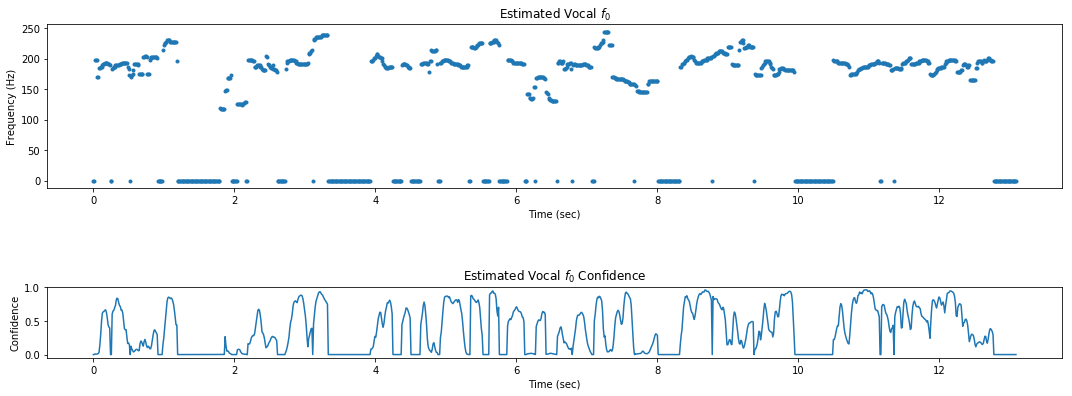

In [8]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(sal_times, f0_estimate_hz, '.')
plt.title("Estimated Vocal $f_0$")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

plt.subplot(413)
plt.plot(sal_times, f0_confidence)
plt.title("Estimated Vocal $f_0$ Confidence")
plt.xlabel("Time (sec)")
plt.ylabel("Confidence")

plt.tight_layout()

plt.show()

## Sonify Output

In [9]:
import mir_eval
import IPython.display as ipd

In [10]:
y = mir_eval.sonify.pitch_contour(sal_times, f0_estimate_hz, 8000, amplitudes=f0_confidence)

In [11]:
ipd.Audio(y, rate=8000)

## Compare with MedleyDB Annotation

In [12]:
import medleydb as mdb

In [13]:
mtrack = mdb.MultiTrack("MusicDelta_Rock")
melody1_annotation = np.array(mtrack.melody1_annotation)

In [14]:
ref_times = melody1_annotation[:, 0]
ref_freqs = melody1_annotation[:, 1]

Text(0, 0.5, 'Frequency (Hz)')

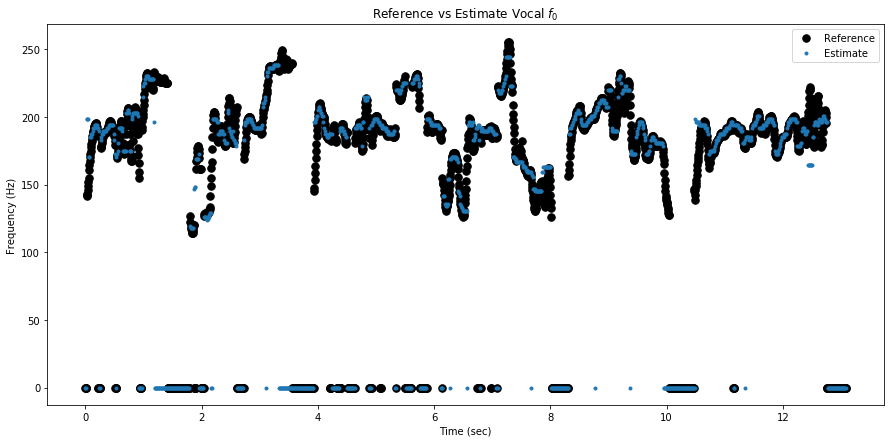

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(ref_times, ref_freqs, '.k', markersize=15, label='Reference')
plt.plot(sal_times, f0_estimate_hz, '.', label='Estimate')
plt.legend()
plt.title("Reference vs Estimate Vocal $f_0$")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

### Evaluate difference

In [16]:
mir_eval.melody.evaluate(ref_times, ref_freqs, sal_times, f0_estimate_hz)

OrderedDict([('Voicing Recall', 0.908169014084507),
             ('Voicing False Alarm', 0.0997920997920998),
             ('Raw Pitch Accuracy', 0.6805633802816902),
             ('Raw Chroma Accuracy', 0.6856338028169014),
             ('Overall Accuracy', 0.7273936170212766)])